# Leapfrog

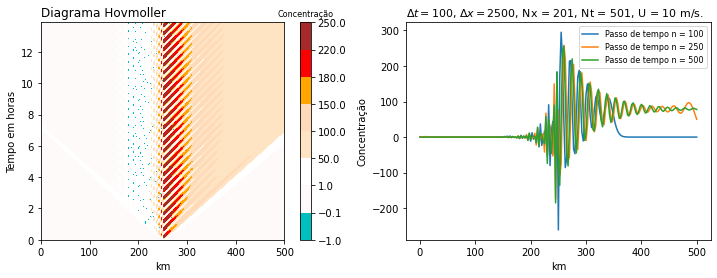

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import imageio.v2 as imageio
import os
from matplotlib import animation, rc
from functions import *
import scipy.sparse as sp

# Condições do exercício
# ----------------------
Nx, dx, Nt, dt, U  = 201, 2500, 501, 100, 10, 
x, _ = np.linspace(0, (Nx-1)*dx, Nx, retstep = True)
t, _ = np.linspace(0, (Nt-1)*dt, Nt, retstep = True)
CFL     = U*dt/dx
ylabel =  ["Concentração","Emissão" ]
C = np.zeros((Nx, Nt))
F = C.copy()
w = int(dx/(dt*U)) # w*dt*U/dx = 1; w*dt = dx
T, X = np.meshgrid(t, x)
om = 2*np.pi/1800
te = 3*3600 # seconds decaimento
K = 1/(te*(om/U)**2) # kappa
v = K*dt/(dx)**2  # nu
# ----------------------

for n in range(1, Nt-1):
    # Euler forward
    if n == 1:
        # Inicialmente F no tempo n, Euler forward-backward
        F[101, n] = 1/2*(wave(t, n) + wave(t, n-1))
        for j in range(1, Nx-1): 
            C[j,n+1] = C[j,n] - CFL*(C[j,n]-C[j-1,n]) + v*(C[j+1,n]-2*C[j,n]+C[j-1,n]) + dt*(F[j,n])
    else: # Fonte e difusão como n-1
        F[101, n-1] = 1/2*(wave(t, n-1) + wave(t, n-2))
        for j in range(1, Nx-1):
            C[j,n+1] = C[j,n-1] - CFL*(C[j+1,n]-C[j-1,n]) + 2*v*(C[j+1,n-1]-2*C[j,n-1]+C[j-1,n-1]) + 2*dt*(F[j,n-1])
    
    # Radiacional
    C[-1, n+1] = C[-1, n] - CFL*(C[-1, n]- C[-2, n]) 

Cl = C.copy()

# Fig
colores = ['c','snow','w','bisque', 'peachpuff','orange', 'r', 'brown','k']
levels=[-1,-.1, 1, 50, 100, 150, 180, 220, 250]
 
fig, (ax, ax2) = plt.subplots(1, 2, figsize=(12,4))
im = ax.contourf(X/1000, T/3600, Cl, levels, origin='lower',  colors=colores)
ax.set_ylabel("Tempo em horas")
ax.set_xlabel("km")
ax.set_title(f"Diagrama Hovmoller", loc='left')
cbar = fig.colorbar(im, ax=ax, orientation="vertical") #fraction=0.04, pad=0.08
cbar.ax.set_title(ylabel[0], fontsize=8)

passos = [ 100, 250, 500]
for n in passos:
    ax2.plot(x/1000, Cl[:,n])
ax2.set_xlabel('km')
ax2.set_ylabel('Concentração')
ax2.set_title(f"$\Delta t = {dt}$, $\Delta x = {dx}$, Nx = {Nx}, Nt = {Nt}, U = {U} m/s.", fontsize=11, loc='left')
ax2.legend([f"Passo de tempo n = {n}" for n in passos], fontsize=8)
fig.savefig("fig/leapfrog.png", dpi = 400, bbox_inches='tight', facecolor='w')

# Leapfrog 2a ordem com operador splitting

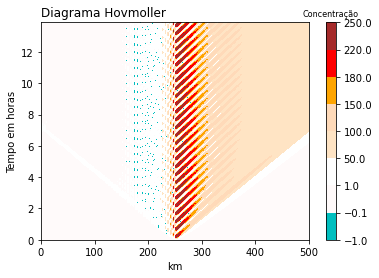

In [2]:
C = np.zeros((Nx, Nt))
Cs = C.copy()
F = C.copy()
levels2=[-10,-.1,.1,1, 4,5, 7, 8, 10]

# F no n-1
# -------
for n in range(1, Nt-1):
    # Euler forward
    if n == 1:
        # Inicialmente F no tempo n, Euler forward-backward
        F[101, n] = 1/2*(wave(t, n) + wave(t, n-1))
        for j in range(1, Nx-1):
            # Passo 1
            # -------
            Cs[j,n+1] = C[j,n] - CFL*(C[j,n]-C[j-1,n]) + v*(C[j+1,n]-2*C[j,n]+C[j-1,n])
            # Passo 2
            # -------
            C[j,n+1] = Cs[j,n+1] + dt*(F[j,n])
            
    else: # Fonte e difusão como n-1
        F[101, n-1] = 1/2*(wave(t, n-1) + wave(t, n-2))
        for j in range(1, Nx-1):
            # Passo 1
            # -------
            Cs[j,n+1] = C[j,n-1] - CFL*(C[j+1,n]-C[j-1,n]) + 2*v*(C[j+1,n-1]-2*C[j,n-1]+C[j-1,n-1])
            # Passo 2
            # -------
            C[j,n+1] = Cs[j,n+1] + 2*dt*F[j,n-1]
    
    # Radiacional
    C[-1, n+1] = C[-1, n] - CFL*(C[-1, n]- C[-2, n])

Csp = C.copy()

hovm(X, T, Csp, F, ylabel, "leapfrog_splitting", n, dt, t, alfa=0, gamma=0, fonte=False, levels=levels)


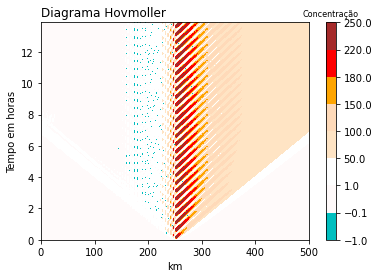

In [3]:
C = np.zeros((Nx, Nt))
Cs = C.copy()
F = C.copy()
gamma = 0.05 #0.1, 0.01
alfa = 0.53 #0.53
f_space, f_time =  True, True
levels2=[-10,-.1,.1,1, 4,5, 7, 8, 10]

# F no n+1
# -------

for n in range(1, Nt-1):
    # Euler forward
    if n == 1:
        # Inicialmente F no tempo n, Euler forward-backward
        F[101, n] = 1/2*(wave(t, n) + wave(t, n-1))
        for j in range(1, Nx-1):
            # Passo 1
            # -------
            Cs[j,n+1] = C[j,n] - CFL*(C[j,n]-C[j-1,n]) + v*(C[j+1,n]-2*C[j,n]+C[j-1,n])
            # Passo 2
            # -------
            C[j,n+1] = Cs[j,n+1] + dt*(F[j,n])
            
    else: # Fonte e difusão como n+1
        F[101, n+1] = 1/2*(wave(t, n+1) + wave(t, n))
        for j in range(1, Nx-1):
            # Passo 1
            # -------
            Cs[j,n+1] = C[j,n-1] - CFL*(C[j+1,n]-C[j-1,n]) + 2*v*(C[j+1,n-1]-2*C[j,n-1]+C[j-1,n-1])
            # Passo 2
            # -------
            C[j,n+1] = Cs[j,n+1] + 2*dt*F[j,n+1]
    
    # Radiacional
    C[-1, n+1] = C[-1, n] - CFL*(C[-1, n]- C[-2, n])

Csp_1 = C.copy()

hovm(X, T, Csp_1, F, ylabel, "leapfrog_splitting_mais1", n, dt, t, alfa=0, gamma=0, fonte=False, levels=levels)


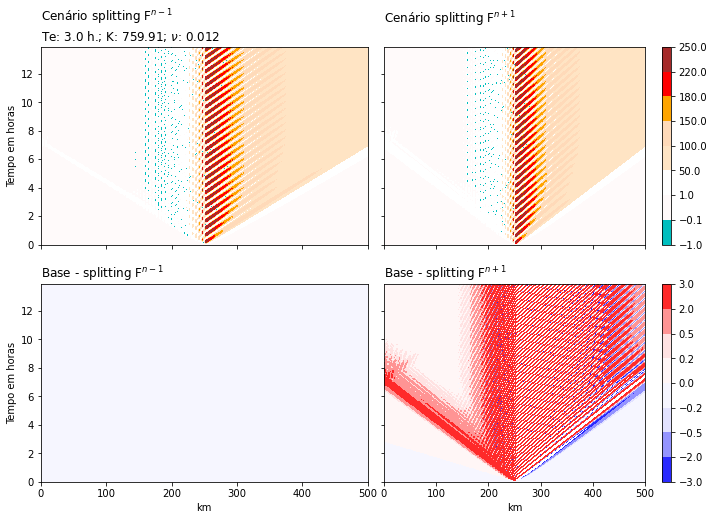

In [4]:
colores = ['c','snow','w','bisque', 'peachpuff','orange', 'r', 'brown','k']
levels2=[-3,-2,-.5,-.2, 0, 0.2, 0.5, 2, 3]
levels=[-1,-.1, 1, 50, 100, 150, 180, 220, 250]
nomes = ['Cenário splitting F$^{n-1}$', 'Cenário splitting F$^{n+1}$\n', 
         'Base - splitting F$^{n-1}$', 'Base - splitting F$^{n+1}$']

Res = {nomes[0]: Csp,     nomes[1]: Csp_1,   nomes[2]:Cl-Csp,  nomes[3]:Cl-Csp_1}
COL = {nomes[0]: colores, nomes[1]: colores, nomes[2]:None,    nomes[3]:None}
CM = {nomes[0]: None,     nomes[1]: None,    nomes[2]:'bwr',   nomes[3]:'bwr'}
LEV = {nomes[0]: levels,  nomes[1]: levels,  nomes[2]:levels2, nomes[3]:levels2}

fig, axes = plt.subplots(2,2, figsize=(12,8), sharey=True, sharex=True, gridspec_kw={'wspace':.05})
for ax, key in zip(axes.flatten(), Res.keys()):
    im = ax.contourf(X/1000, T/3600, Res[key], LEV[key], origin='lower',
                            colors=COL[key], cmap=CM[key])
    
    if (key == nomes[0]) | (key == nomes[2]):
        ax.set_ylabel("Tempo em horas")
    
    if key == nomes[0]:
        ax.set_title(f"{key}\nTe: { te/3600} h.; K: {round(K,2)}; $\\nu$: {round(v,3)}", loc='left')
    else:
        ax.set_title(f"{key}", loc='left')
        
    if (key == nomes[2]) | (key == nomes[3]):
        ax.set_xlabel("km")
    if (key == nomes[1]) | (key == nomes[3]):
        cbar = fig.colorbar(im, ax=ax,orientation="vertical")

fig.savefig("fig/leapfrog_diff.png", dpi = 400, bbox_inches='tight', facecolor='w')

0.9826272725448311


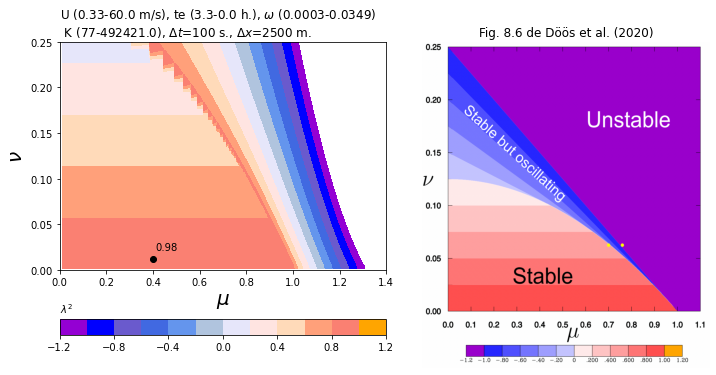

In [27]:
# Figure 8.6 Doos 2020 com F = 0
mu = U*dt/dx
k = om/U # numero de onda
K = 1/(te*k**2) # kappa
v = K*dt/(dx)**2  # nu
a = mu * np.sin(k*dx)
b = v * np.sin(k*dx/2)**2
lb = lambda a, b: 1 - 8*b if 1 - 8*b - a**2 > 0 else -(2*a** + 8*b - 1 + 2*a*np.sqrt(a**2+8*b-1))
lb_ex3 = lb(a, b)
print(lb_ex3)

colores = ['darkviolet','blue','slateblue','royalblue', 'cornflowerblue',
           'lightsteelblue', 'lavender', 'mistyrose','peachpuff', 'lightsalmon',
           'salmon', 'orange']

# Variação da U, mantendo 
Us = np.linspace(U/30, U*6, 1000)
oms = np.linspace(om/10, om*10, 1000)
mus = Us*dt/dx # CFLs
ks = oms/Us # números de onda

# Variação do K (kappa) podendo varia te
tes = np.linspace(te*1.1, te/1800, 1000)
Ks = 1/(tes*ks**2) # kappas
vs = Ks*dt/(dx)**2  # nu

MUS, VS = np.meshgrid(mus, vs)
lamb = np.zeros(MUS.shape)*np.nan

for i in range(len(vs)):
    for j in range(len(mus)):
        a = mus[j] * np.sin(ks[j]*dx)      
        b = vs[i] * (np.sin(ks[i]*dx/2))**2
        key = 1 - 8*b - a**2
        if key > 0:
            lamb[i,j] = 1 - 8*b
        elif key < 0:
            lamb[i,j] = -(2*a** + 8*b - 1 + 2*a*np.sqrt(a**2+8*b-1))
         
fig, (ax, ax2) = plt.subplots(1,2, figsize=(12,6), gridspec_kw={'wspace':.05} )
im = ax.contourf(MUS, VS, lamb, levels= np.arange(-1.2,1.4,.2), colors=colores  ) # 
cbar = fig.colorbar(im, ax=ax,orientation="horizontal")
cbar.ax.set_title('$\lambda ^2$', fontsize=10, loc='left')
ax.set_xlabel("$\mu$", fontsize=20, fontweight='bold')
ax.set_ylabel("$\\nu$", fontsize=20, fontweight='bold')
ax.set_xlim(0, 1.4)
ax.set_ylim(0, 0.25)
ax.scatter(mu, v, c="k")
ax.text(mu+.01, v+.01, str(round(lb_ex3,2)))
ax.set_title(f"U ({round(Us[0],2)}-{round(Us[-1],2)} m/s), te ({round(tes[0]/3600,2)}-{round(tes[-1]/3600,2)} h.), $\omega$ ({round(oms[0],4)}-{round(oms[-1],4)})\
    \n K ({round(Ks[0])}-{round(Ks[-1],0)}), $\Delta t$={dt} s., $\Delta x$={dx} m.", loc='left')
im2 = plt.imread('fig/fig8_6_doos.png')
ax2.imshow(im2, extent=(-0.1, 1, 0.2, 1.45))
ax2.set_title("Fig. 8.6 de Döös et al. (2020)")
ax2.axis('off')
fig.savefig("fig/estabilidade.png", dpi = 400, bbox_inches='tight', facecolor='w')

In [12]:
filenames = []
# plot the line chart
for n in range(0,Nt,2):
    fig, ax = plt.subplots(figsize=[12,4])
    ax.plot(x/1000, Cl[:,n], color = 'g', linestyle = 'solid', label="Leapfrog 2")
    ax.plot(x/1000, Csp[:,n], color = 'crimson', linestyle = 'solid', label="Leapfrog splitting")
    ax.set_ylim(-50,400)
    ax.set_title(f"N° passo tempo={n}.")
    ax.legend()
    ax.set_ylabel(ylabel[0])

    # create file name and append it to a list
    filename = f'fig/gifs/{n}.png'
    filenames.append(filename)

    # save frame
    fig.savefig(filename, dpi=300)
    plt.close() # build gif

with imageio.get_writer('gifs/leap_split.gif', mode='I', duration = .2) as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    
# Remove files
for filename in set(filenames):
    os.remove(filename)  